In [2]:
!pip install virtualenv
# mkvirtualenv


     |████████████████████████████████| 7.2MB 3.9MB/s 
     |████████████████████████████████| 337kB 49.2MB/s 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install mlens

     |████████████████████████████████| 235kB 3.6MB/s 


In [4]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from xgboost import XGBRegressor

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_validate, cross_val_score
from sklearn.feature_selection import RFECV
from mlens.ensemble import SuperLearner
from sklearn.pipeline import Pipeline

# Metrics
from sklearn.metrics import auc, roc_curve, roc_auc_score, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report


# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6
from pylab import *

[MLENS] backend: threading


In [5]:
pip freeze > requirements.txt

In [6]:
!pwd

/content


In [7]:
pip install -r requirements.txt

# 1. Понимание бизнеса

## 1.1 Цель
Предсказать качество португальского вина

## 1.2 Описание
Эти два набора данных относятся к красному и белому вариантам португальского вина "Vinho Verde". Из-за проблем конфиденциальности и логистики доступны только физико-химические (входные данные) и сенсорные (выходные данные) переменные (например, нет данных о сортах винограда, марке вина, цене продажи вина и т. д.).

Эти наборы данных можно рассматривать как задачи классификации или регрессии. Классы упорядочены и не сбалансированы (например, нормальных вин гораздо больше, чем отличных или плохих). Алгоритмы обнаружения выбросов могут быть использованы для обнаружения нескольких превосходных или плохих вин.


[Описание от Kaggle](https://www.kaggle.com/rajyellow46/wine-quality) [Текст ссылки](https://)

# 2. Data Understanding

## 2.1 Import Libraries

1-фиксированная кислотность 
2-Летучая кислотность 
3-лимонная кислота 
4-остаточный сахар 
5-хлориды 
6-свободный диоксид серы 
7-общий диоксид серы 
8-Плотность 
9-рН 
10-сульфаты 
11-алкоголь 
Выходная переменная (на основе сенсорных данных): 
12-качество (оценка от 0 до 10 баллов)

In [8]:
# from google.colab import files
# uploaded = files.upload()

## 2.2 Вспомогательные функции

In [15]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( data ):
    corr = data.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

def score(clf, x_train, x_test, y_train, y_test):
    try:
        y_pred_train, y_pred_test = clf.predict_proba(x_train)[:, 1], clf.predict_proba(x_test)[:, 1]
        print(f'Train-test roc auc: {roc_auc_score(y_train.astype(bool), y_pred_train)}, {roc_auc_score(y_test.astype(bool), y_pred_test)}')
    except AttributeError:
        y_pred_train, y_pred_test = clf.predict(x_train), clf.predict(x_test)
        print(f'Train-test r2 score: {r2_score(y_train, y_pred_train)}, {r2_score(y_test, y_pred_test)}')
      

## 2.3 Загрузка данных

In [16]:
# data = pd.read_csv('winequalityN.csv')
data = pd.read_csv('/content/drive/MyDrive/test_tasks/задача_вины/winequalityN.csv')

## 2.4 Статистика и визуализации

In [17]:
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


**Описание переменных**

 - fixed acidity: фиксированная кислотность 
 - volatile acidity: Летучая кислотность 
 - citric acid: лимонная кислота 
 - residual sugar: остаточный сахар 
 - chlorides: хлориды 
 - free sulfur dioxide: свободный диоксид серы 
 - total sulfur dioxide: общий диоксид серы 
 - density: Плотность 
 - pH: рН 
 - sulphates: сульфаты 
 - alcohol: алкоголь 


   Переменная, которую надо предсказать (на основе принятых перечисленных  выше данных): 
 - quality: качество (оценка от 0 до 10 баллов)


[Больше информации на сайте Kaggle]((https://www.kaggle.com/rajyellow46/wine-quality))

### 2.4.1 Далее взглянем на некоторую ключевую информацию о переменных
Числовая переменная - это переменная со значениями в области целых или действительных чисел, в то время как категориальная переменная - это переменная, которая может принимать одно из ограниченного и обычно фиксированного числа возможных значений, таких как тип крови.

Обратите особое внимание на тип каждой переменной, количество наблюдений и некоторые значения переменных.



In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [19]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fixed acidity,6487.0,7.216579,1.296750,3.80000,6.40000,7.00000,7.70000,15.90000
volatile acidity,6489.0,0.339691,0.164649,0.08000,0.23000,0.29000,0.40000,1.58000
citric acid,6494.0,0.318722,0.145265,0.00000,0.25000,0.31000,0.39000,1.66000
residual sugar,6495.0,5.444326,4.758125,0.60000,1.80000,3.00000,8.10000,65.80000
chlorides,6495.0,0.056042,0.035036,0.00900,0.03800,0.04700,0.06500,0.61100
free sulfur dioxide,6497.0,30.525319,17.749400,1.00000,17.00000,29.00000,41.00000,289.00000
total sulfur dioxide,6497.0,115.744574,56.521855,6.00000,77.00000,118.00000,156.00000,440.00000
density,6497.0,0.994697,0.002999,0.98711,0.99234,0.99489,0.99699,1.03898
pH,6488.0,3.218395,0.160748,2.72000,3.11000,3.21000,3.32000,4.01000
sulphates,6493.0,0.531215,0.148814,0.22000,0.43000,0.51000,0.60000,2.00000


### 2.4.2 Тепловая карта корреляции может дать нам понимание того, какие переменные важны

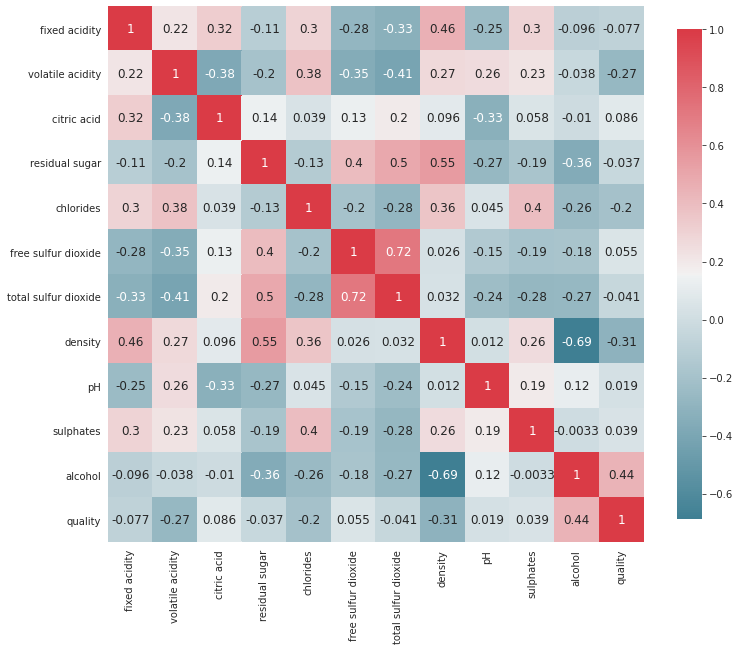

In [20]:
plot_correlation_map( data )

### 2.4.3 Давайте подробнее рассмотрим взаимосвязь между процентом алкоголя и качеством вина
Начнем с рассмотрения взаимосвязи между процентом алкоголя и качеством вина.

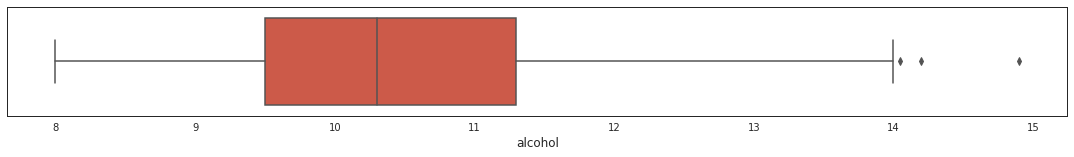

In [21]:
plt.figure(figsize=(19,2))
sns.boxplot(x=data['alcohol'])

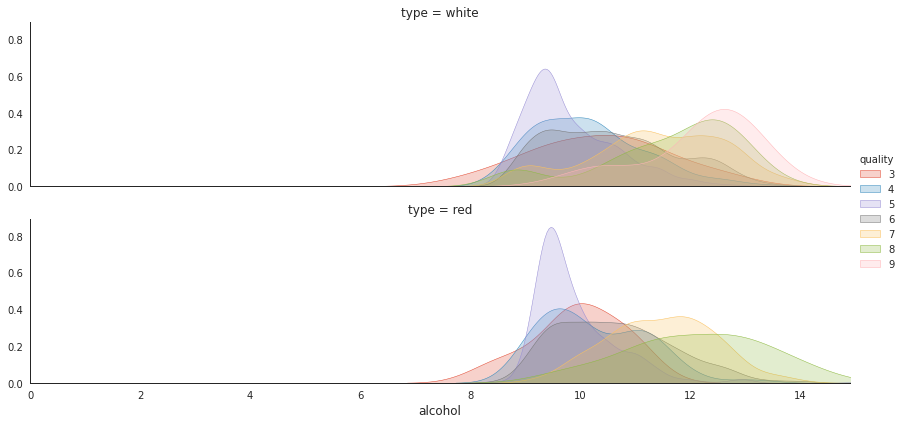

In [22]:
# Plot distributions of Alcohol and wine's quality
plot_distribution( data , var = 'alcohol' , target = 'quality' , row = 'type' )

Рассмотрим графики выше. Различия между выживаемостью для разных значений - это то, что будет использоваться для разделения целевой переменной (в данном случае - выживаемости) в модели. Если бы две линии были примерно одинаковыми, то это не было бы хорошей переменной для нашей прогностической модели.

### 2.4.4 Тип вина
Мы также можем посмотреть на категориальную переменную "тип вина" и ее связью с качеством

- white = белое вина  
- red = красное вино


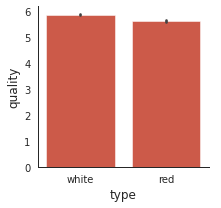

In [23]:
# Plot quality rate by type
plot_categories( data , cat = 'type' , target = 'quality' )

# 3. Data Preparation

## 3.1 Категориальные переменные должны быть преобразованы в числовые переменные

Переменная type рассматривается как категориальная переменная. Некоторые из  алгоритмов могут обрабатывать только числовые значения, поэтому нам нужно создать новую (фиктивную) переменную для каждого уникального значения категориальных переменных (LabelEncoding), назовем ее cat_feat. Остальные переменные будут носить наименование num_feat.
Теперь белое вино=1, красное=0.

In [24]:
cat_feat_data = data[['type']].apply(LabelEncoder().fit_transform)
num_feat_data = data.drop(['type'], axis=1)
data = pd.concat([num_feat_data, cat_feat_data], axis=1)
cat_feat = cat_feat_data.columns
num_feat = num_feat_data.columns
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1


## 3.2 Заполнить пропущенные значения в переменных
Большинство алгоритмов машинного обучения требуют, чтобы все переменные имели значения, чтобы использовать их для обучения модели. Самый простой метод - заполнить пропущенные значения средним по переменной для всех наблюдений в обучающем наборе. Но более логично проанализировать возможные варианты по остальным признакам, и заполнить подобными

In [25]:
data.isnull().sum()

fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
type                     0
dtype: int64

In [26]:
print('Для фиксированной кислотности пустых строк ' + str( len( data[ pd.isnull( data['fixed acidity'] ) ] ) ))
print('Для летучей кислотности пустых строк ' + str( len( data[ pd.isnull( data['volatile acidity'] ) ] ) ))
print('Для лимонной кислоты пустых строк ' + str( len( data[ pd.isnull( data['citric acid'] ) ] ) ))
print('Для остаточного сахара пустых строк ' + str( len( data[ pd.isnull( data['residual sugar'] ) ] ) ))
print('Для хлоридов пустых строк ' + str( len( data[ pd.isnull( data['chlorides'] ) ] ) ))
print('Для Ph пустых строк ' + str( len( data[ pd.isnull( data['pH'] ) ] ) ))
print('Для сульфатов пустых строк ' + str( len( data[ pd.isnull( data['sulphates'] ) ] ) ))
print('Всего строк в наборе ' + str( len( data ) ))

Для фиксированной кислотности пустых строк 10
Для летучей кислотности пустых строк 8
Для лимонной кислоты пустых строк 3
Для остаточного сахара пустых строк 2
Для хлоридов пустых строк 2
Для Ph пустых строк 9
Для сульфатов пустых строк 4
Всего строк в наборе 6497


Очевидно, что химические реакции связаны между собой, это значит, что необходимо отследить зависимость фиксированной кислоности и летучей кислотности, хлоридов и тд и на основании этих данных заполнить пустые

In [27]:
data.corrwith(data['fixed acidity']).sort_values(ascending=False)

fixed acidity           1.000000
density                 0.459204
citric acid             0.323736
sulphates               0.300380
chlorides               0.298421
volatile acidity        0.220172
quality                -0.077031
alcohol                -0.095603
residual sugar         -0.112319
pH                     -0.251814
free sulfur dioxide    -0.283317
total sulfur dioxide   -0.329747
type                   -0.487241
dtype: float64

In [28]:
data[data['fixed acidity'].isnull()].groupby('density').head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
17,NaN,0.660,0.48,1.2,0.029,29.0,75.0,0.98920,3.33,0.39,12.8,8,1
174,NaN,0.270,0.31,17.7,0.051,33.0,173.0,0.99900,3.09,0.64,10.2,5,1
249,NaN,0.410,0.14,10.4,0.037,18.0,119.0,0.99600,3.38,0.45,10.0,5,1
267,NaN,0.580,0.07,6.9,0.043,34.0,149.0,0.99440,3.34,0.57,9.7,5,1
368,NaN,0.290,0.48,2.3,0.049,36.0,178.0,0.99310,3.17,0.64,10.6,6,1
518,NaN,0.130,0.28,1.9,0.050,20.0,78.0,0.99180,3.43,0.64,10.8,6,1
1079,NaN,NaN,0.29,6.2,0.046,29.0,227.0,0.99520,3.29,0.53,10.1,6,1
2902,NaN,0.360,0.14,8.9,0.036,38.0,155.0,0.99622,3.27,NaN,9.4,5,1
6428,NaN,0.440,0.09,2.2,0.063,9.0,18.0,0.99444,NaN,0.69,11.3,6,0
6429,NaN,0.705,0.10,2.8,0.081,13.0,28.0,0.99631,NaN,0.66,10.2,5,0


In [29]:
((data.groupby('fixed acidity')['density'].value_counts()).sort_values(ascending=False))

fixed acidity  density
7.4            0.99860    13
7.0            0.99540    12
6.4            0.99480     9
7.3            0.99807     8
6.8            0.99530     8
                          ..
7.2            0.99930     1
               0.99920     1
               0.99900     1
               0.99800     1
3.8            0.99248     1
Name: density, Length: 4188, dtype: int64

Судя по данным корреляции и результатам выше, чем выше плотность, тем выше фиксированная кислотность

In [30]:
data.loc[data['fixed acidity'].isnull(), 'fixed acidity'] = data.groupby('density')['fixed acidity'].transform('mean')
data.loc[data['fixed acidity'].isnull(), 'fixed acidity'] = data.loc[(data['density']>0.9963)&(data['density']<0.9964)]['fixed acidity'].mean()
data[data['fixed acidity'].isnull()]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type


Пустых значений в переменной фиксированной кислотности больше нет. Проделаем то же самое с остальными пропущенными - на основании корреляции заполним все средние

In [31]:
data.corrwith(data['volatile acidity']).sort_values(ascending=False)

volatile acidity        1.000000
chlorides               0.377167
density                 0.271193
pH                      0.260660
sulphates               0.225476
fixed acidity           0.219796
alcohol                -0.038248
residual sugar         -0.196702
quality                -0.265953
free sulfur dioxide    -0.353230
citric acid            -0.378061
total sulfur dioxide   -0.414928
type                   -0.652875
dtype: float64

In [32]:
((data.groupby('volatile acidity')['chlorides'].value_counts()).sort_values(ascending=False))

volatile acidity  chlorides
0.22              0.044        20
0.32              0.050        18
0.24              0.050        17
0.23              0.044        17
0.28              0.040        17
                               ..
0.44              0.095         1
                  0.100         1
                  0.107         1
                  0.114         1
0.37              0.025         1
Name: chlorides, Length: 2668, dtype: int64

In [33]:
data.loc[data['volatile acidity'].isnull(), 'volatile acidity'] = data.groupby('chlorides')['volatile acidity'].transform('mean')
data[data['volatile acidity'].isnull()]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type


In [34]:
data.corrwith(data['citric acid']).sort_values(ascending=False)

citric acid             1.000000
fixed acidity           0.323108
total sulfur dioxide    0.195218
type                    0.187126
residual sugar          0.142486
free sulfur dioxide     0.133437
density                 0.096320
quality                 0.085706
sulphates               0.057613
chlorides               0.039315
alcohol                -0.010433
pH                     -0.328689
volatile acidity       -0.377678
dtype: float64

In [35]:
data.loc[data['citric acid'].isnull(), 'citric acid'] = data.groupby('citric acid')['fixed acidity'].transform('mean')
data.loc[data['citric acid'].isnull(), 'citric acid'] = data.groupby('citric acid')['volatile acidity'].transform('mean')
data.loc[data['citric acid'].isnull(), 'citric acid'] = data.groupby('citric acid')['pH'].transform('mean')
data.loc[data['citric acid'].isnull(), 'citric acid'] = data.loc[(data['fixed acidity']>5.2)&(data['fixed acidity']<5.4)]['citric acid'].mean()
data[data['citric acid'].isnull()]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type


In [36]:
data.corrwith(data['pH']).sort_values(ascending=False)

pH                      1.000000
volatile acidity        0.260118
sulphates               0.191248
alcohol                 0.121002
chlorides               0.044806
quality                 0.019366
density                 0.011920
free sulfur dioxide    -0.145191
total sulfur dioxide   -0.237687
fixed acidity          -0.251813
residual sugar         -0.267050
citric acid            -0.328686
type                   -0.328727
dtype: float64

In [37]:
((data.groupby('volatile acidity')['pH'].value_counts()).sort_values())#ascending=False))

volatile acidity  pH  
1.58              3.50     1
0.28              3.53     1
                  3.45     1
                  3.41     1
                  3.40     1
                          ..
0.23              3.23    15
0.27              3.16    15
0.20              3.14    15
0.21              3.25    16
0.30              3.18    16
Name: pH, Length: 2628, dtype: int64

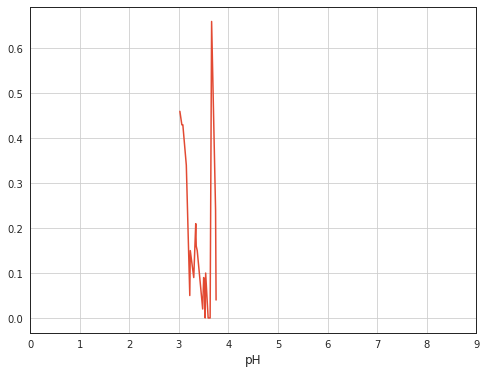

In [38]:
data[(data['volatile acidity']>1)].groupby(['pH'])['citric acid'].sum().plot(grid=True, xticks=range(0,10))


In [39]:
data.loc[(data['pH'].isnull())&(data['volatile acidity']>=0.2)&(data['volatile acidity']<=0.23), 'pH'] \
= data.groupby('volatile acidity')['pH'].transform('mean')
data.loc[(data['pH'].isnull())&(data['volatile acidity']>=0.28)&(data['volatile acidity']<=0.32), 'pH'] \
= data.groupby('volatile acidity')['pH'].transform('mean')
data.loc[(data['pH'].isnull())&(data['volatile acidity']>=0.43)&(data['volatile acidity']<=0.45), 'pH'] \
= data.groupby('volatile acidity')['pH'].transform('mean')
data.loc[(data['pH'].isnull())&(data['volatile acidity']>=0.695)&(data['volatile acidity']<=0.71), 'pH'] \
= data.groupby('volatile acidity')['pH'].transform('mean')
data[data['pH'].isnull()]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type


In [40]:
data.corrwith(data['sulphates']).sort_values(ascending=False)

sulphates               1.000000
chlorides               0.395332
fixed acidity           0.300390
density                 0.259454
volatile acidity        0.225491
pH                      0.191274
citric acid             0.057391
quality                 0.038729
alcohol                -0.003261
residual sugar         -0.185745
free sulfur dioxide    -0.188489
total sulfur dioxide   -0.275381
type                   -0.486916
dtype: float64

In [41]:
data['sulphates'].value_counts()

0.50    275
0.46    243
0.54    234
0.44    232
0.38    214
       ... 
1.59      1
1.12      1
1.33      1
1.56      1
1.62      1
Name: sulphates, Length: 111, dtype: int64

In [42]:
((data.groupby('chlorides')['sulphates'].value_counts()).sort_values(ascending=False))

chlorides  sulphates
0.047      0.46         18
0.044      0.46         16
0.036      0.44         15
0.044      0.48         15
0.054      0.50         15
                        ..
0.069      0.62          1
           0.63          1
           0.72          1
           0.74          1
0.009      0.37          1
Name: sulphates, Length: 2617, dtype: int64

In [43]:
data.loc[data['sulphates'].isnull(), 'sulphates'] = data.groupby('chlorides')['sulphates'].transform('mean')
data[data['sulphates'].isnull()]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type


In [44]:
data.corrwith(data['residual sugar']).sort_values(ascending=False)

residual sugar          1.000000
density                 0.552498
total sulfur dioxide    0.495820
free sulfur dioxide     0.403439
type                    0.349000
citric acid             0.142336
quality                -0.036825
fixed acidity          -0.111727
chlorides              -0.128902
sulphates              -0.185771
volatile acidity       -0.196394
pH                     -0.266812
alcohol                -0.359706
dtype: float64

In [45]:
data.loc[data['residual sugar'].isnull(), 'residual sugar'] = data.groupby('density')['residual sugar'].transform('mean')
data[data['residual sugar'].isnull()]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type


In [46]:
data.corrwith(data['chlorides']).sort_values(ascending=False)

chlorides               1.000000
sulphates               0.395272
volatile acidity        0.377340
density                 0.362594
fixed acidity           0.298402
pH                      0.044908
citric acid             0.039301
residual sugar         -0.128864
free sulfur dioxide    -0.195042
quality                -0.200886
alcohol                -0.256861
total sulfur dioxide   -0.279580
type                   -0.512622
dtype: float64

In [47]:
data.loc[data['chlorides'].isnull(), 'chlorides'] = data.groupby('sulphates')['chlorides'].transform('mean')
data[data['chlorides'].isnull()]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type


In [48]:
data.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
dtype: int64

Больше пропущенных значений нет,- не будет проблем, связанными с ними, при построении некоторых моделей построении

## 3.4 Сборка финальных датасетов для моделирования

In [49]:
y = data['quality']
X = data.drop(['quality'], axis=1)

### 3.4.2 Создание датасетов

Отделяем данные для обучения и для проверки

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape, y_train.shape, X_test.shape, y_train.shape

((4872, 12), (4872,), (1625, 12), (4872,))

### 3.4.3 Важность признаков
Отбор оптимальных признаков для модели имеет важное значение. Теперь мы попытаемся оценить, какие переменные являются наиболее важными, чтобы сделать прогноз.

1.0


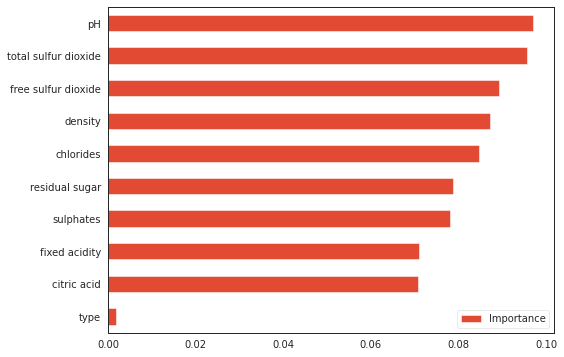

In [51]:
plot_variable_importance(X_train, y_train)

# 4. Моделирование
Теперь мы выберем модель, которую хотели бы попробовать. Используем обучающий набор данных для обучения модели и затем проверим ее с помощью тестового набора.

## 4.1 Выбор модели
Хорошей отправной точкой является Бустинг.

In [52]:
model_cat = XGBClassifier(n_estimators=1000, learning_rate=0.2, max_depth=4, silent=True)


## 4.2 Обучение модели

In [53]:
model_cat.fit( X_train , y_train )

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1, verbosity=1)

# 5. Оценка
Теперь мы собираемся оценить модель

## 5.1 Модель
Мы можем оценить точность модели, используя набор для валидации, где мы знаем фактический результат. Этот набор данных не использовался для обучения, поэтому он абсолютно новый для модели.

Затем мы сравниваем точность с точностью при использовании модели на тренировочных данных. Если разница между ними значительна, это свидетельствует о переобучении. Мы стараемся избегать этого, потому что это означает, что модель не будет хорошо обобщаться на новые данные (будет работать плохо)

In [54]:
#print (score(model_cat, X_train, X_test, y_train, y_test))
print (model_cat.score( X_train , y_train ) , model_cat.score( X_test , y_test ))

1.0 0.6406153846153846


In [55]:
#Линейную регрессию
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_test = model_lr.predict(X_test)
y_pred_train = model_lr.predict(X_train)
print("R2: \t", r2_score(y_train, y_pred_train),r2_score(y_test, y_pred_test))

R2: 	 0.30314392022906467 0.2745757281151677


In [56]:
#Бустинг
model_cat = XGBRegressor(n_estimators=1000, learning_rate=0.2, max_depth=4, silent=True)
model_cat.fit(X_train, y_train)
y_pred_test = model_cat.predict(X_test)
y_pred_train = model_cat.predict(X_train)
print(mean_squared_error(y_train, y_pred_train), mean_squared_error(y_test, y_pred_test))
print(r2_score(y_train, y_pred_train), r2_score(y_test, y_pred_test)  )   

0.023859540140933024 0.43292584500239145
0.9684752567464097 0.44386319835598365


# Качество модели не очень высокое. Попробуем стекинг

In [57]:
skf = KFold(n_splits=10, random_state=None, shuffle=False)
train_metric, test_metric = [], []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    clf_tree = RandomForestRegressor(n_estimators=1000, max_features=5)
    clf_tree.fit(X_train, y_train)
    y_pred_train_rf, y_pred_test_rf = model_cat.predict(X_train), model_cat.predict(X_test)
    mean_squared_error(y_train, y_pred_train_rf), mean_squared_error(y_test, y_pred_test_rf)
    train_metric.append(r2_score(y_train, y_pred_train_rf))
    test_metric.append(r2_score(y_test, y_pred_test_rf))
    print(r2_score(y_train, y_pred_train_rf), r2_score(y_test, y_pred_test_rf))
print(sum(train_metric)/len(train_metric))
print(sum(test_metric)/len(test_metric))

0.8373602514032766 0.8090730508092561
0.8388051949949706 0.8034238435909583
0.8352025828454878 0.828448528305023
0.8346980185497551 0.825469482926461
0.8321071017070111 0.8463517251783759
0.8323645983324467 0.8431455978069101
0.8339742024202282 0.840711628354924
0.8304891593936263 0.8759420007447632
0.8333308159172416 0.8398882561091444
0.8365629908965366 0.8103244393253765
0.834489491646058
0.8322778553151192
